# Biochar lifetime analysis

Here we present a simple toy model for evaluating the carbon removal and permanence of biochar projects. The data and analysis method is based directly on two publications

- Spokas (2010) Review of the stability of biochar in soils: predictability of O:C molar ratios, Carbon Management, doi: 10.4155/CMT.10.32

- Campbell et al. (2018) Potential carbon storage in biochar made from logging residue: Basic principles and Southern Oregon case studies, PLOS One, doi: 10.1371/journal.pone.0203475

### Notebook setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import arange, zeros, exp, log, array, percentile
from pandas import read_csv

### The basic model

Campbell et al. (2018) present a simple model for biochar carbon dynamics by comparing the carbon content of biomass after biocharing to the carbon content that would have resided in the form of the source feedstock (e.g. logging residues).

The difference is

$∆ = C_{biochar} - C_{biochar}$

And the mass of carbon in both is modeled using a first-order differential equation

$C_t = C_{t-1}e^{-k} + C_{input}$

We'll write a function that generates a complete carbon curve as a function of the input and the parameter k over 1000 years

In [2]:
def model(t, initial, k):
    return initial * exp(-k * t)

And we can now plot carbon curves for both unmodified residue and biochar over a fixed duration, assuming an initial carbon content of 20 tC for the residue and 12 tC for the biochar (which would be achieved through a pyrolysis process with 60% efficiency).

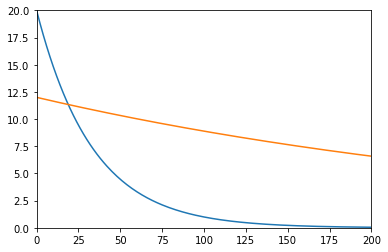

In [3]:
t = arange(1000)
residue = model(t, 20, 0.03)
biochar = model(t, 12, 0.003)
plt.plot(t, residue)
plt.plot(t, biochar)
plt.xlim([0, 200])
plt.ylim([0, 20]);

This precisely matches Figure 1A from Campbell et al. (2019)

These curves makes clear that biochar is not removing carbon per se, but rather avoiding the emissions that would have been associated with the corresponding feedstock. For that reason, the appropriate quantity is the difference between the two curves.

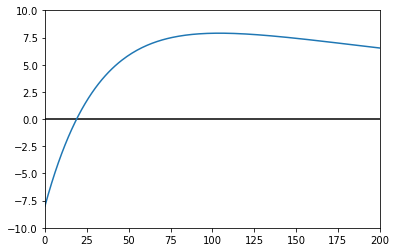

In [4]:
plt.plot(t, biochar-residue)
plt.xlim([0, 200])
plt.ylim([-10, 10])
plt.hlines(0, 0, 200);

As this curve makes clear, the cumulative effective carbon removal is initially negative, quickly reaches a compensation point, and then reaches a point termed by Campbell et al. (2018) as "climate parity" where the storage 

### Mapping O:C ratios to half life

A key parameter in the above model is the decay rate (also referred to as the biochar's recalcitrance). Campbell et al. (2018) find that this parameter has little effect on the time at which climate parity is achieved, so long as it 10 times greater than the decay rate feedstock. But it is also importantly related to the permanence, or time scale over which the carbon stored in the biochar remain.

We can use data digitized from a meta-analysis by Spokas (2010) that relate the oxygen to carbon (O:C) molar ratio to the predicted half-life of synthetic biochar in various laboratory conditions.

In [5]:
data = read_csv('biochar.csv')

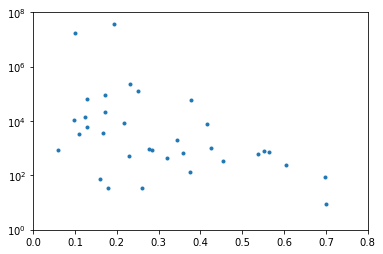

In [6]:
plt.plot(data.ratio, data.halflife, '.')
plt.xlim([0, 0.8])
plt.ylim([1, 10**8])
plt.yscale('log');

We fit a simple linear model in log space so we can predict half-life as a function of ratio

First we'll setup out fitting tools (in this case we're using PyStan)

In [7]:
import pystan
import logging
logger = logging.getLogger('pystan')
logger.setLevel('ERROR')

Now we'll define our linear model

In [8]:
model_code = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

Then build our model

In [9]:
sm = pystan.StanModel(model_code=model_code)

And run the sampler

In [10]:
fit = sm.sampling(data=dict(x=data.ratio, y=log(data.halflife), N=34), iter=1000, warmup=500, thin=1, seed=101, n_jobs=1)
result = fit.to_dataframe(permuted=True)
alpha = result['alpha']
beta = result['beta']

We can plot regression lines with parameters sampled from the posterior to get a sense of the variability

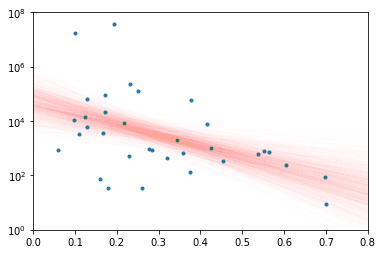

In [11]:
plt.plot(data.ratio, data.halflife, '.')
xhat = arange(0,1,0.1)
for i in range(1000):
    yhat = exp(alpha[i] + beta[i] * xhat)
    plt.plot(xhat, yhat, color='orange', alpha=0.005)
plt.yscale('log')
plt.xlim([0, 0.8])
plt.ylim([1, 10**8]);

Finally we write a simple function that, for a given ratio, returns the posterior predictive value at a given percentile.

In [12]:
def predict(ratio, prctile):
    dist = exp(alpha + beta * ratio)
    return percentile(dist, [prctile])[0]

### project evaluation

We can now use the above to evaluate some aspects of a biochar projects. If we assume a project reports an O:C ratio of 0.08, we can use the simple linear model above to we can compute a half-life. We use the 2.5th percentile of the posterior predictive distribution as a crude, highly conservative estimate, given that permanence is only weakly correlated with composition, and likely depends as much or more so on the decay environment, which is often unknown.

In [13]:
ratio = 0.08
halflife = predict(ratio, 2.5)

Still, given the decay kinetics assumed by our toy model, we can compute a decay constant from the half-life

In [14]:
k = log(2) / halflife

We can now determine the duration after which a fixed percent of the biohar remains. For a target of 90% for example, we get the following number of years.

In [15]:
fraction = 0.90
years = -log(fraction) / k

We can summarize our parameters

In [16]:
print('summary')
print('-------')
print('half-life: ' + str(halflife) + ' years')
print('fraction: ' + str(fraction))
print('k: ' + str(k))
print('years: ' + str(years))

summary
-------
half-life: 4474.311081437289 years
fraction: 0.9
k: 0.00015491707392354236
years: 680.1091254139349


And we can plot this on the decay curve from above, assuming a starting volume of 12 tC

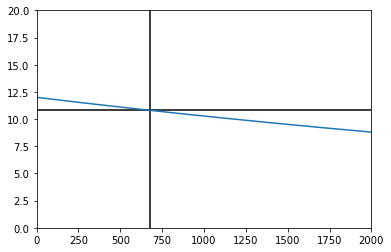

In [17]:
t = arange(0, 20000)
biochar = model(t, 12, k)
plt.plot(t, biochar);
plt.ylim([0, 20])
plt.xlim([0, 2000])
plt.vlines(years, 0, 20)
plt.hlines(12 * 0.90, 0, 20000);

In general, validating the volume and permanence for an actual biochar project requires knowing the composition (and thus recalcitrance), but perhaps more importantly, also requires knowing the conversion efficiency (the fraction of initial feedstock carbon retained in biochar after pyrolysis) and the decay rate of the feedstock. That said, simply by knowing the recalcitrance, and making some assumptions, we can approximate a permanence over which a fixed fraction of volume is likely to remain.